<a href="https://colab.research.google.com/github/boskidisanalysis/cosmo-analysis/blob/main/cosmoanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install astropy astroquery


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 42.6 MB/s eta 0:00:00


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM, LambdaCDM, WMAP9, Planck18
from astropy import units as u
from astropy.io import ascii
import pandas as pd
from scipy import stats
from astroquery.sdss import SDSS
from astroquery.ipac.ned import Ned
from astropy.coordinates import SkyCoord
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import warnings
warnings.filterwarnings('ignore')

class CosmologyAnalyzer:
    def __init__(self):
        # Define cosmological models
        self.models = {
            'Planck18': Planck18,
            'WMAP9': WMAP9,
            'Einstein-de Sitter': FlatLambdaCDM(H0=70, Om0=1.0),
            'Open': LambdaCDM(H0=70, Om0=0.3, Ode0=0.0),
            'Custom Lambda-CDM': FlatLambdaCDM(H0=70, Om0=0.3)
        }

        # Configure retry strategy for API calls
        self.session = requests.Session()
        retries = Retry(total=5,
                       backoff_factor=1,
                       status_forcelist=[500, 502, 503, 504])
        self.session.mount('https://', HTTPAdapter(max_retries=retries))

    def calculate_luminosity_distance(self, redshift, model_name='Planck18'):
        """
        Calculate the luminosity distance for a given redshift using the specified cosmological model.
        """
        # Input validation
        if not isinstance(redshift, (int, float)):
            raise ValueError("Redshift must be a number")

        if redshift < 0:
            raise ValueError("Redshift cannot be negative")

        if model_name not in self.models:
            raise ValueError(f"Unknown model: {model_name}. Available models: {list(self.models.keys())}")

        try:
            # Get the cosmological model
            cosmo = self.models[model_name]

            # Calculate luminosity distance
            distance = cosmo.luminosity_distance(redshift).value  # Returns value in Mpc

            return distance

        except Exception as e:
            raise ValueError(f"Error calculating luminosity distance: {str(e)}")

    def generate_sample_data(self, n_samples=100):
        """Generate sample galaxy data when online services are unavailable."""
        np.random.seed(42)  # For reproducibility

        # Generate realistic redshift distribution
        redshifts = np.random.lognormal(mean=-1, sigma=0.5, size=n_samples)
        redshifts = redshifts[redshifts < 2.0]  # Filter out unrealistic values

        # Calculate distances using Planck18 model with some noise
        true_distances = [self.calculate_luminosity_distance(z, 'Planck18')
                         for z in redshifts]

        # Add some realistic noise to distances
        noise_factor = 0.05  # 5% uncertainty
        noisy_distances = np.array(true_distances) * (1 + np.random.normal(0, noise_factor, len(true_distances)))

        # Create DataFrame
        df = pd.DataFrame({
            'redshift': redshifts,
            'distance': noisy_distances,
            'redshift_err': redshifts * 0.01,  # 1% redshift uncertainty
            'distance_err': noisy_distances * noise_factor
        })

        return df

    def fetch_sdss_data(self, limit=1000, min_z=0.1, max_z=0.5, use_sample=False):
        """Fetch galaxy data from SDSS DR17 or generate sample data"""
        if use_sample:
            print("Using generated sample data instead of SDSS query...")
            return self.generate_sample_data(limit)

        try:
            print("Querying SDSS database...")
            query = f"""
            SELECT TOP {limit}
                z as redshift,
                zErr as redshift_err,
                ra,
                dec
            FROM SpecObj
            WHERE
                class = 'GALAXY'
                AND z BETWEEN {min_z} AND {max_z}
                AND zErr > 0
                AND zErr < 0.01
                AND zWarning = 0
            """

            results = SDSS.query_sql(query)

            if results is None or len(results) == 0:
                print("No data returned from SDSS query, using generated sample data...")
                return self.generate_sample_data(limit)

            df = results.to_pandas()
            print(f"Retrieved {len(df)} galaxies from SDSS")

            print("Calculating luminosity distances...")
            df['distance'] = [self.calculate_luminosity_distance(z, 'Planck18')
                            for z in df['redshift']]
            df['distance_err'] = df['distance'] * df['redshift_err'] / df['redshift']

            return df

        except Exception as e:
            print(f"Error fetching SDSS data: {e}")
            print("Falling back to generated sample data...")
            return self.generate_sample_data(limit)

    def fetch_ned_data(self, sample_size=100, max_retries=3, use_sample=False):
        """Fetch galaxy data from NED with retry logic"""
        if use_sample:
            print("Using generated sample data instead of NED query...")
            return self.generate_sample_data(sample_size)

        for attempt in range(max_retries):
            try:
                print(f"Querying NED database (attempt {attempt + 1}/{max_retries})...")

                result_table = Ned.query_region(
                    coordinates=SkyCoord(ra=180, dec=0, unit="deg"),
                    radius=5.0 * u.deg,
                    equinox='J2000.0'
                )

                if result_table is None or len(result_table) == 0:
                    print("No data returned from NED query")
                    if attempt == max_retries - 1:
                        print("Falling back to generated sample data...")
                        return self.generate_sample_data(sample_size)
                    time.sleep(2 ** attempt)
                    continue

                df = result_table.to_pandas()
                print(f"Retrieved {len(df)} objects from NED")

                df = df[df['Redshift'].notna()]
                df['redshift'] = pd.to_numeric(df['Redshift'], errors='coerce')
                df = df.dropna(subset=['redshift'])
                df = df[df['redshift'].between(0, 10)]

                if len(df) > sample_size:
                    df = df.head(sample_size)

                print("Calculating luminosity distances...")
                df['distance'] = [self.calculate_luminosity_distance(z, 'Planck18')
                                for z in df['redshift']]

                df['redshift_err'] = df['redshift'] * 0.01
                df['distance_err'] = df['distance'] * 0.01

                print(f"Successfully processed {len(df)} galaxies from NED")
                return df

            except Exception as e:
                print(f"Error on attempt {attempt + 1}: {e}")
                if attempt == max_retries - 1:
                    print("Falling back to generated sample data...")
                    return self.generate_sample_data(sample_size)
                time.sleep(2 ** attempt)

    def calculate_model_statistics(self, data, model_name):
        """Calculate statistical metrics for a given cosmological model against observed data."""
        model_distances = np.array([self.calculate_luminosity_distance(z, model_name)
                                  for z in data['redshift']])

        residuals = data['distance'] - model_distances

        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))

        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((data['distance'] - np.mean(data['distance']))**2)
        r_squared = 1 - (ss_res / ss_tot)

        if 'distance_err' in data.columns:
            chi_squared = np.sum(residuals**2 / data['distance_err']**2)
            reduced_chi_squared = chi_squared / (len(data) - 1)
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan

        return {
            'model': model_name,
            'rmse': rmse,
            'mae': mae,
            'r_squared': r_squared,
            'chi_squared': chi_squared,
            'reduced_chi_squared': reduced_chi_squared,
            'n_points': len(data)
        }

    def compare_all_models(self, data):
        """Compare all available cosmological models against the observed data."""
        required_cols = ['redshift', 'distance']
        if not all(col in data.columns for col in required_cols):
            raise ValueError(f"Data must contain columns: {required_cols}")

        stats_list = []
        for model_name in self.models.keys():
            try:
                stats = self.calculate_model_statistics(data, model_name)
                stats_list.append(stats)
            except Exception as e:
                print(f"Warning: Error calculating statistics for {model_name}: {e}")
                continue

        stats_df = pd.DataFrame(stats_list)

        numeric_cols = ['rmse', 'mae', 'r_squared', 'chi_squared', 'reduced_chi_squared']
        stats_df[numeric_cols] = stats_df[numeric_cols].round(4)

        stats_df = stats_df.sort_values('rmse')

        return stats_df

    def plot_model_comparison_with_residuals(self, data):
        """Create a comparison plot showing data points, model predictions, and residuals."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), height_ratios=[2, 1])
        fig.suptitle('Cosmological Model Comparison')

        if 'distance_err' in data.columns:
            ax1.errorbar(data['redshift'], data['distance'],
                        yerr=data['distance_err'],
                        fmt='o', color='black', alpha=0.5,
                        label='Observed Data', markersize=4)
        else:
            ax1.scatter(data['redshift'], data['distance'],
                       color='black', alpha=0.5,
                       label='Observed Data', s=20)

        z_range = np.linspace(min(data['redshift']), max(data['redshift']), 100)
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.models)))

        for (model_name, _), color in zip(self.models.items(), colors):
            distances = [self.calculate_luminosity_distance(z, model_name) for z in z_range]
            ax1.plot(z_range, distances, '-', label=model_name, color=color, alpha=0.7)

            model_distances = [self.calculate_luminosity_distance(z, model_name)
                             for z in data['redshift']]
            residuals = data['distance'] - model_distances
            ax2.scatter(data['redshift'], residuals, color=color, alpha=0.5, s=20)
            ax2.plot(z_range, np.zeros_like(z_range), '--', color='gray', alpha=0.5)

        ax1.set_xlabel('Redshift')
        ax1.set_ylabel('Luminosity Distance (Mpc)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)

        ax2.set_xlabel('Redshift')
        ax2.set_ylabel('Residuals (Mpc)')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig
    def run_analysis(use_sample_data=False, local_data_path=None):
        """
        Run the cosmological analysis using either online data, sample data, or local data.

        Parameters
        ----------
        use_sample_data : bool, optional
            If True, uses generated sample data instead of querying online services
        local_data_path : str, optional
            Path to local data file. If provided, uses this instead of online/sample data.
            The file should be a CSV with at least 'redshift' and 'distance' columns.
            Optional columns: 'redshift_err', 'distance_err'
        """
        analyzer = CosmologyAnalyzer()

        if local_data_path:
            try:
                print(f"\nLoading local data from {local_data_path}...")
                data = pd.read_csv(local_data_path)
                required_cols = ['redshift', 'distance']
                if not all(col in data.columns for col in required_cols):
                    raise ValueError(f"Local data must contain columns: {required_cols}")

                print("Analyzing local data...")
                stats_df = analyzer.compare_all_models(data)
                print("\nModel Comparison Statistics (Local Data):")
                print(stats_df)

                print("\nGenerating plots for local data...")
                comparison_plot = analyzer.plot_model_comparison_with_residuals(data)
                if comparison_plot:
                    plt.show()
            except Exception as e:
                print(f"Error processing local data: {str(e)}")
                print("Falling back to sample/online data...")
                local_data_path = None  # Fall back to online/sample data

        if not local_data_path:  # Run online/sample analysis if no local data or if local data failed
            try:
                # Fetch data from SDSS
                print("\nFetching SDSS data...")
                sdss_data = analyzer.fetch_sdss_data(limit=500, use_sample=use_sample_data)

                if sdss_data is not None:
                    print("\nCalculating model statistics for SDSS data...")
                    stats_df = analyzer.compare_all_models(sdss_data)
                    print("\nModel Comparison Statistics (SDSS data):")
                    print(stats_df)

                    print("\nGenerating plots for SDSS data...")
                    comparison_plot = analyzer.plot_model_comparison_with_residuals(sdss_data)
                    if comparison_plot:
                        plt.show()
            except Exception as e:
                print(f"Error processing SDSS data: {str(e)}")

            try:
                # Fetch NED data
                print("\nFetching NED data...")
                ned_data = analyzer.fetch_ned_data(sample_size=50, use_sample=use_sample_data)

                if ned_data is not None:
                    print("\nCalculating model statistics for NED data...")
                    ned_stats_df = analyzer.compare_all_models(ned_data)
                    print("\nModel Comparison Statistics (NED data):")
                    print(ned_stats_df)

                    print("\nGenerating plots for NED data...")
                    ned_comparison_plot = analyzer.plot_model_comparison_with_residuals(ned_data)
                    if ned_comparison_plot:
                        plt.show()
            except Exception as e:
                print(f"Error processing NED data: {str(e)}")




Fetching SDSS data...
Using generated sample data instead of SDSS query...

Calculating model statistics for SDSS data...

Model Comparison Statistics (SDSS data):
                model      rmse       mae  r_squared  chi_squared  \
0            Planck18  161.2195   99.5577     0.9889     480.3096   
1               WMAP9  164.9059  103.4418     0.9884     522.9293   
4   Custom Lambda-CDM  175.5508  112.9022     0.9869     627.9085   
3                Open  379.9186  281.7232     0.9385    2709.6853   
2  Einstein-de Sitter  644.0164  462.6406     0.8234    6144.7884   

   reduced_chi_squared  n_points  
0               0.9645       499  
1               1.0501       499  
4               1.2609       499  
3               5.4411       499  
2              12.3389       499  

Generating plots for SDSS data...


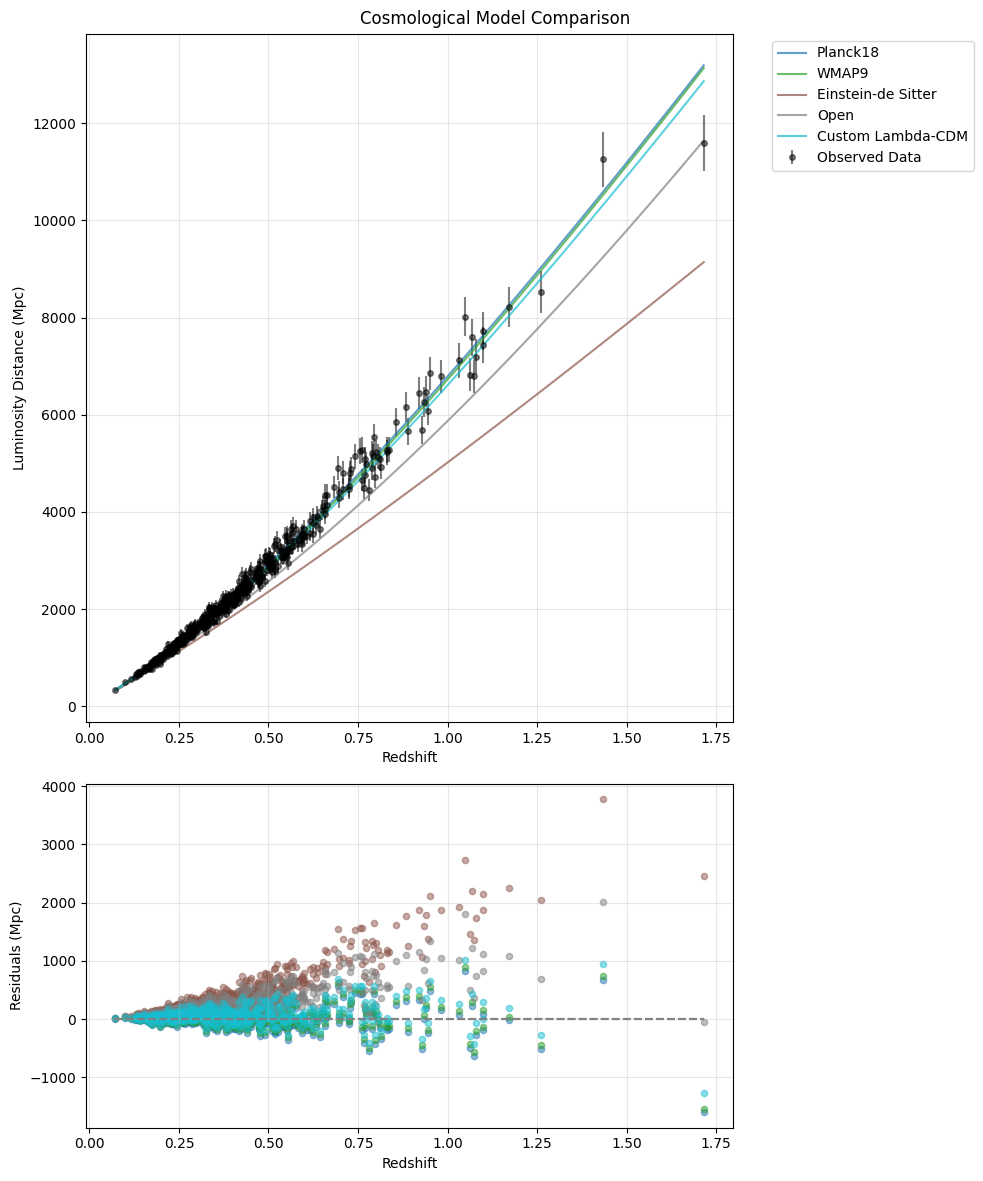


Fetching NED data...
Using generated sample data instead of NED query...

Calculating model statistics for NED data...

Model Comparison Statistics (NED data):
                model      rmse       mae  r_squared  chi_squared  \
0            Planck18   86.8586   67.0700     0.9951      39.7363   
1               WMAP9   97.6762   74.8578     0.9937      43.5577   
4   Custom Lambda-CDM  118.4576   90.1418     0.9908      54.7211   
3                Open  318.0821  244.1402     0.9337     252.8082   
2  Einstein-de Sitter  514.6143  379.9043     0.8265     552.0721   

   reduced_chi_squared  n_points  
0               0.8109        50  
1               0.8889        50  
4               1.1168        50  
3               5.1594        50  
2              11.2668        50  

Generating plots for NED data...


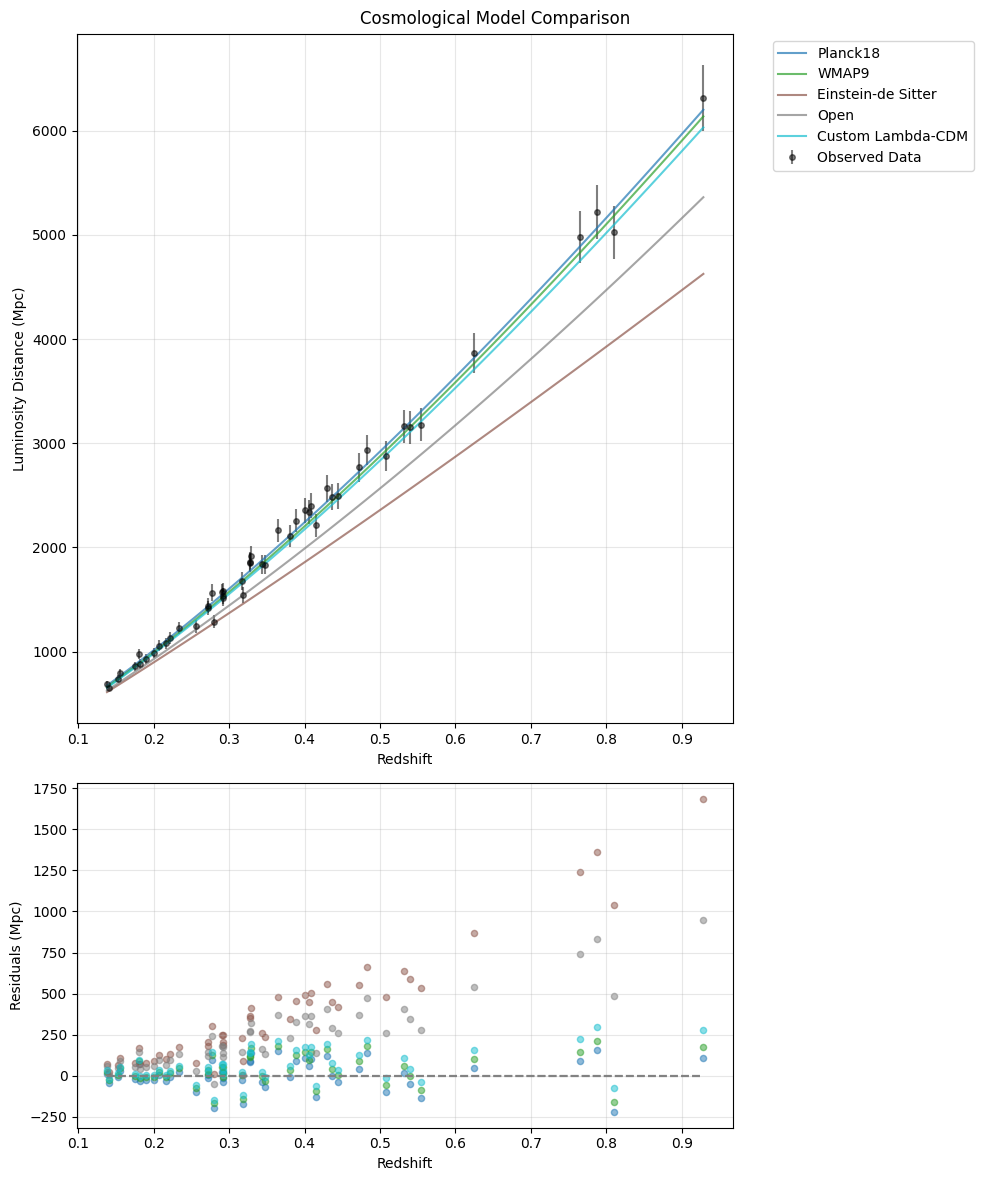

In [17]:
run_analysis(use_sample_data=True)


Fetching SDSS data...
Querying SDSS database...
Retrieved 500 galaxies from SDSS
Calculating luminosity distances...

Calculating model statistics for SDSS data...

Model Comparison Statistics (SDSS data):
                model      rmse       mae  r_squared   chi_squared  \
0            Planck18    0.0000    0.0000     1.0000  0.000000e+00   
1               WMAP9   30.1731   27.8036     0.9986  1.124640e+07   
4   Custom Lambda-CDM   53.2278   47.7310     0.9956  2.856860e+07   
3                Open  195.0962  162.4994     0.9416  2.362391e+08   
2  Einstein-de Sitter  298.7650  243.2926     0.8629  4.921415e+08   

   reduced_chi_squared  n_points  
0               0.0000       500  
1           22537.8842       500  
4           57251.7102       500  
3          473425.1129       500  
2          986255.4552       500  

Generating plots for SDSS data...


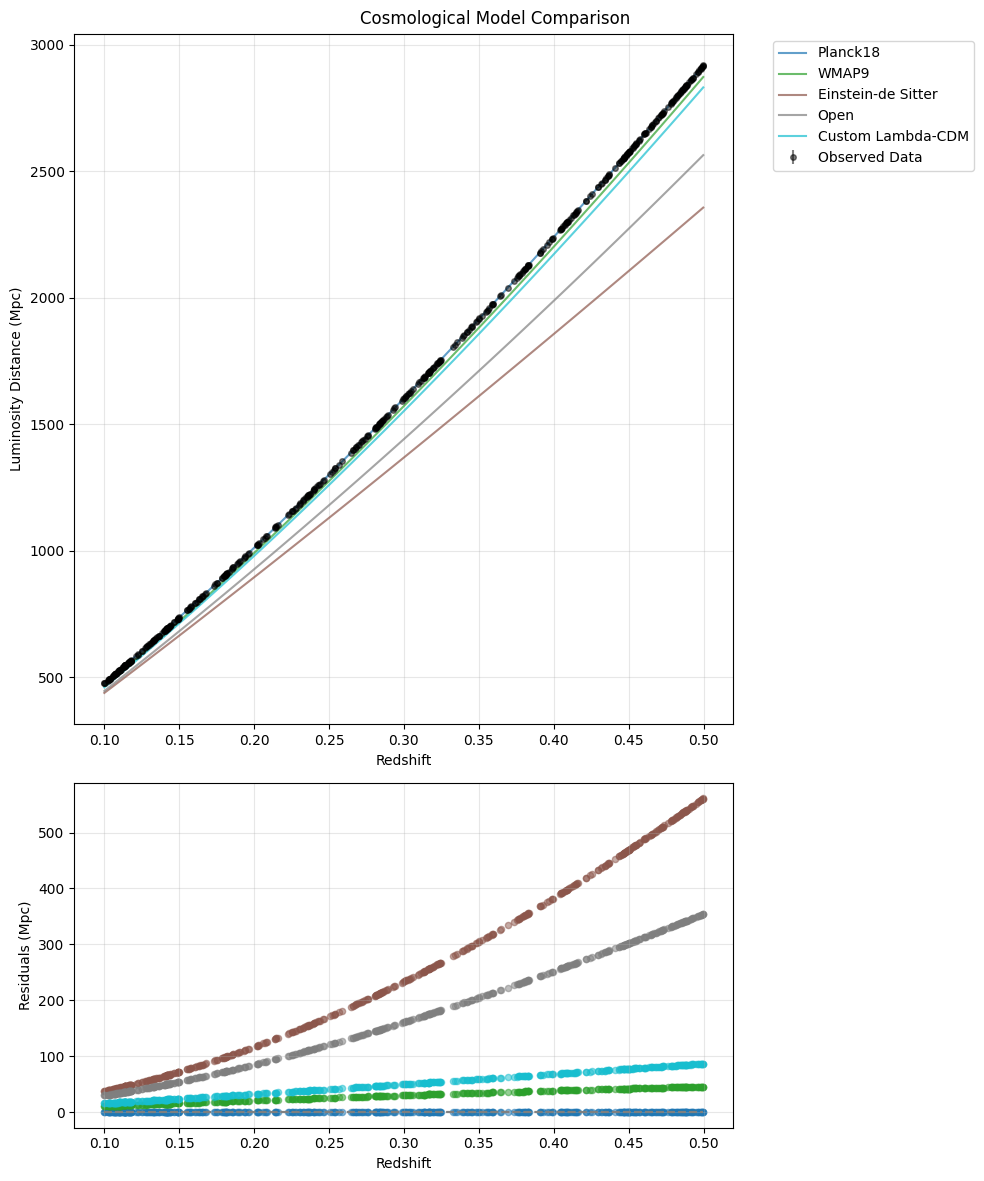


Fetching NED data...
Querying NED database (attempt 1/3)...
Error on attempt 1: HTTPSConnectionPool(host='ned.ipac.caltech.edu', port=443): Read timed out.
Querying NED database (attempt 2/3)...
Error on attempt 2: HTTPSConnectionPool(host='ned.ipac.caltech.edu', port=443): Read timed out.
Querying NED database (attempt 3/3)...
Error on attempt 3: HTTPSConnectionPool(host='ned.ipac.caltech.edu', port=443): Read timed out.
Falling back to generated sample data...

Calculating model statistics for NED data...

Model Comparison Statistics (NED data):
                model      rmse       mae  r_squared  chi_squared  \
0            Planck18   86.8586   67.0700     0.9951      39.7363   
1               WMAP9   97.6762   74.8578     0.9937      43.5577   
4   Custom Lambda-CDM  118.4576   90.1418     0.9908      54.7211   
3                Open  318.0821  244.1402     0.9337     252.8082   
2  Einstein-de Sitter  514.6143  379.9043     0.8265     552.0721   

   reduced_chi_squared  n_poin

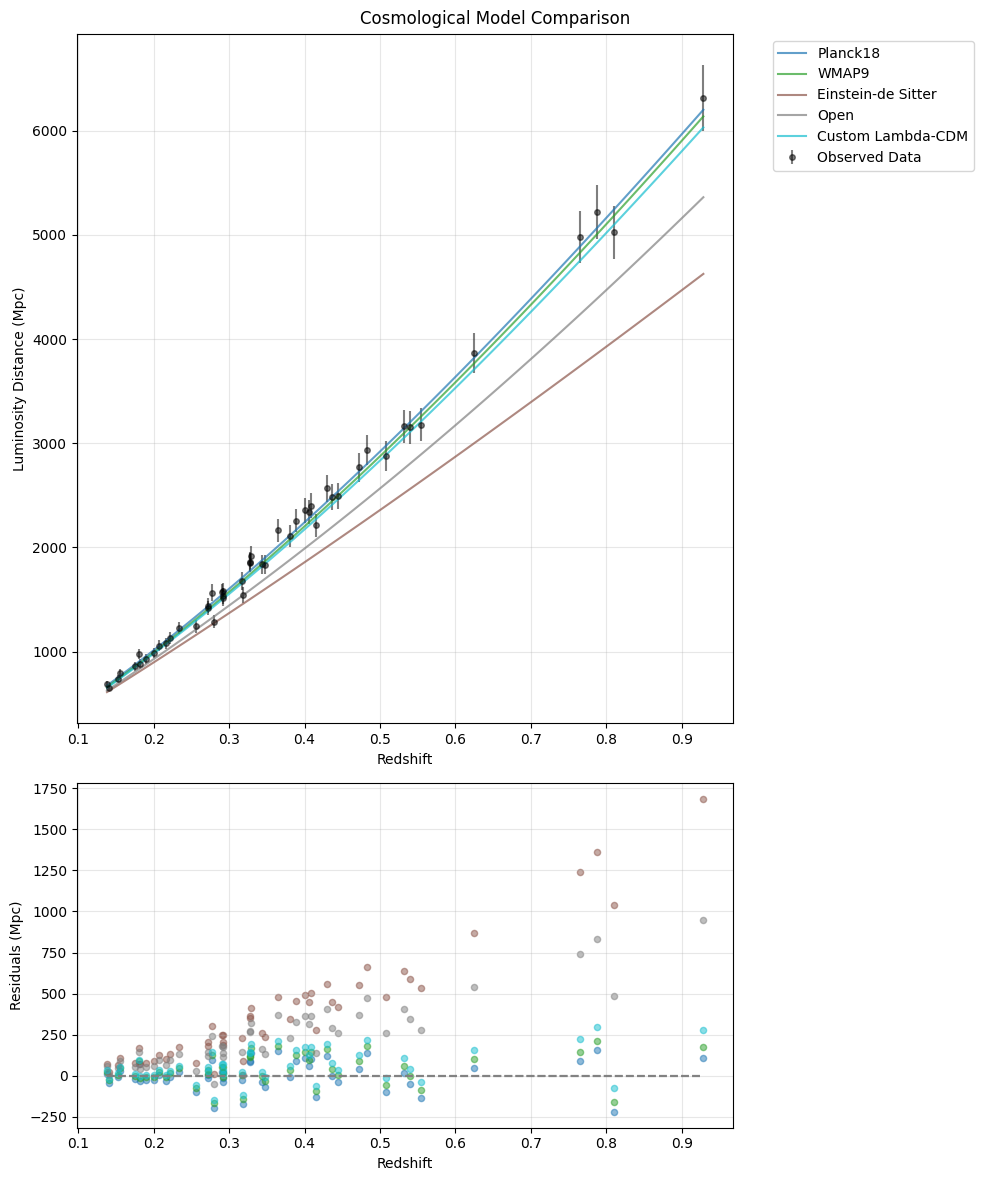

In [18]:
run_analysis(use_sample_data=False)